Nobel Shan Setiono - 2602080762

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
DIR = "dataset/"
SIFT = cv2.SIFT.create()
ORB = cv2.ORB.create()
FLANN = cv2.FlannBasedMatcher(dict(algorithm = 1), dict(checks = 50))
BFMATCHER_ORB = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
BFMATCHER_SIFT = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [9]:
def createMasking(mask, match):
    for i, (fm, sm) in enumerate(match):
        if fm.distance < 0.7 * sm.distance:
            mask[i] = [1, 0]
    return mask

def showImage(method, res):
    imgs = res[method]
    plt.figure(figsize=(100, 20))
    for idx, match_img in enumerate(imgs):
        draw_rgb = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 1, idx + 1)
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.title(f'{method} - Pair {idx + 1}')
    plt.tight_layout()
    plt.show()


In [10]:
def keypointMatch(img_scene, img_target, algorithm, matcher):
    if algorithm == 'ORB':
        kp_scene, ds_scene = ORB.detectAndCompute(img_scene, None)
        kp_target, ds_target = ORB.detectAndCompute(img_target, None)
    elif algorithm == 'SIFT':
        kp_scene, ds_scene = SIFT.detectAndCompute(img_scene, None)
        kp_target, ds_target = SIFT.detectAndCompute(img_target, None)
    else :
        return 'invalid'
    
    if matcher == "FLANN" or algorithm == "SIFT":
        ds_scene = np.float32(ds_scene)
        ds_target = np.float32(ds_target)

    if matcher == "BF":
        if algorithm == 'ORB':
            match = BFMATCHER_ORB.match(ds_target, ds_scene)
        elif algorithm == 'SIFT':
            match = BFMATCHER_SIFT.match(ds_target, ds_scene)
        match = sorted(match, key= lambda x : x.distance)
        return cv2.drawMatches(
            img_target, kp_target, 
            img_scene, kp_scene,
            match[:20], None,  
            matchColor=[255, 0, 0], flags= 2
        )
    elif matcher == "FLANN":
        match = FLANN.knnMatch(ds_target, ds_scene, 2)
        mask = [[0, 0] for i in range(0, len(match))]
        mask_match = createMasking(mask, match)
        draw = dict(
            matchColor=(255, 0,  0),
            singlePointColor=(0, 255, 0),
            matchesMask=mask_match,
            flags=cv2.DrawMatchesFlags_DEFAULT
        )
        return cv2.drawMatchesKnn(
            img_target, kp_target, 
            img_scene, kp_scene,
            match, None, **draw
        )
    else :
        return 'invalid'

    

In [11]:
scenes = os.listdir(DIR + "scene/")
targets = os.listdir(DIR + "target/")

RES = {
    'ORB_BF' : [],
    'ORB_FLANN' : [],
    'SIFT_BF' : [],
    'SIFT_FLANN' : []
    }

for scene, target in zip(scenes, targets):
    img_target = cv2.imread(DIR + "target/" + target, cv2.COLOR_BGR2GRAY)
    img_scene = cv2.imread(DIR + "scene/" + scene, cv2.COLOR_BGR2GRAY)

    img_target = cv2.cvtColor(img_target, cv2.COLOR_BGR2GRAY)
    img_scene = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

    RES['ORB_BF'].append(keypointMatch(img_scene, img_target, "ORB", "BF"))

    RES['ORB_FLANN'].append(keypointMatch(img_scene, img_target, "ORB", "FLANN"))

    RES['SIFT_BF'].append(keypointMatch(img_scene, img_target, "SIFT", "BF"))

    RES['SIFT_FLANN'].append(keypointMatch(img_scene, img_target, "SIFT","FLANN"))


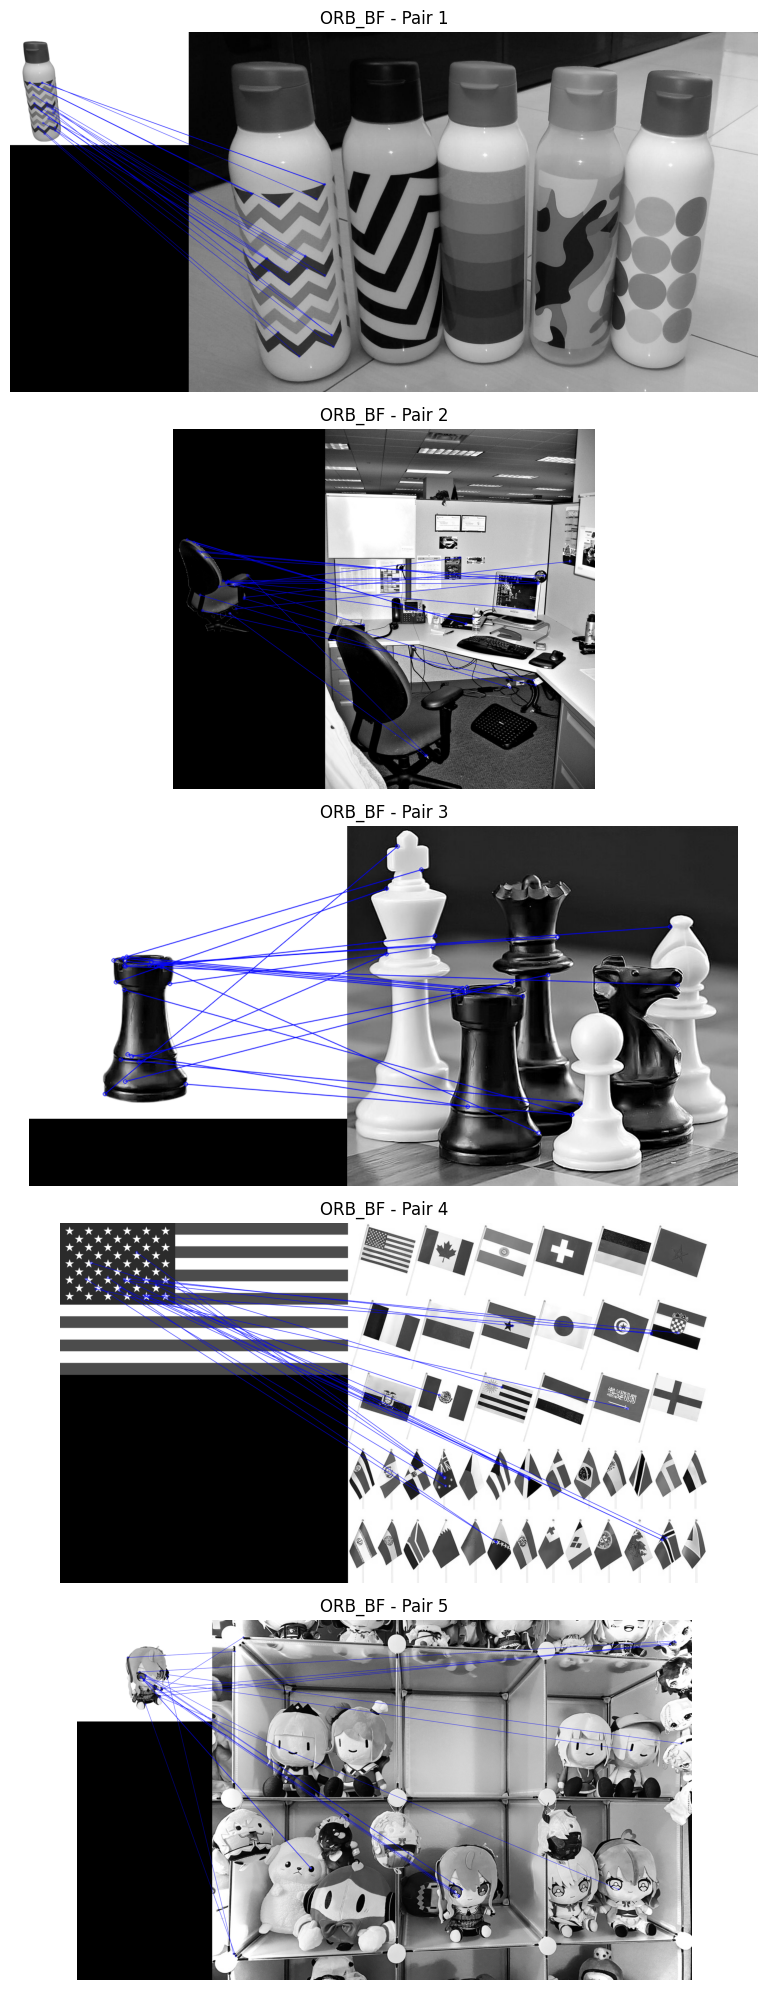

In [12]:
showImage("ORB_BF", RES)

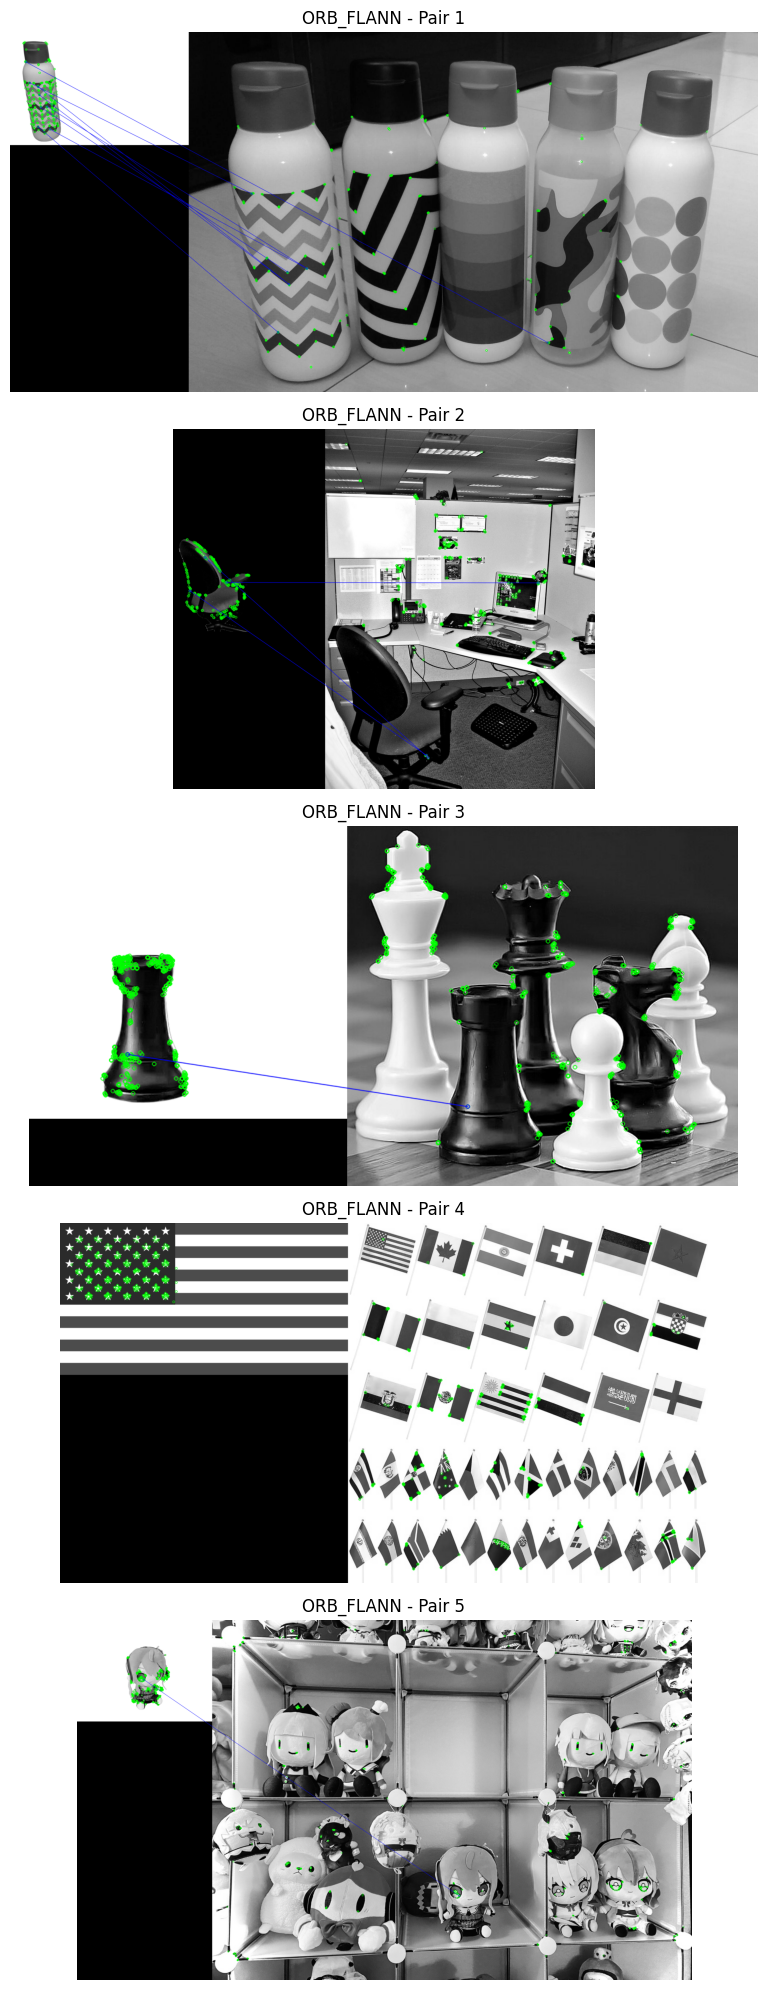

In [13]:
showImage("ORB_FLANN", RES)

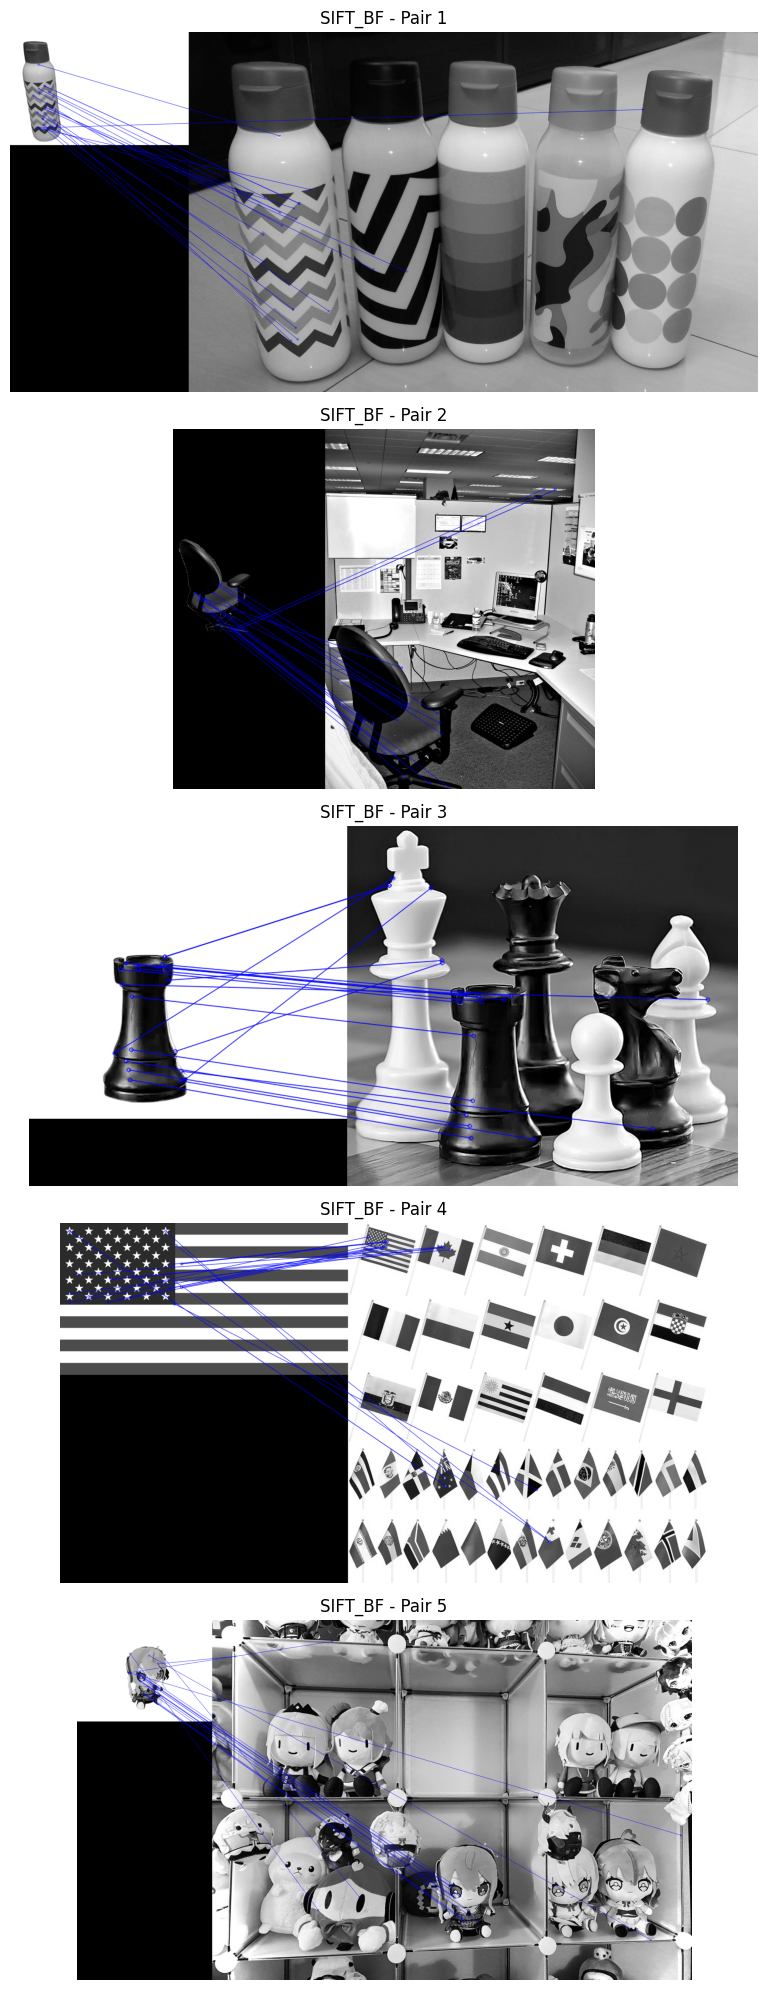

In [14]:
showImage("SIFT_BF", RES)

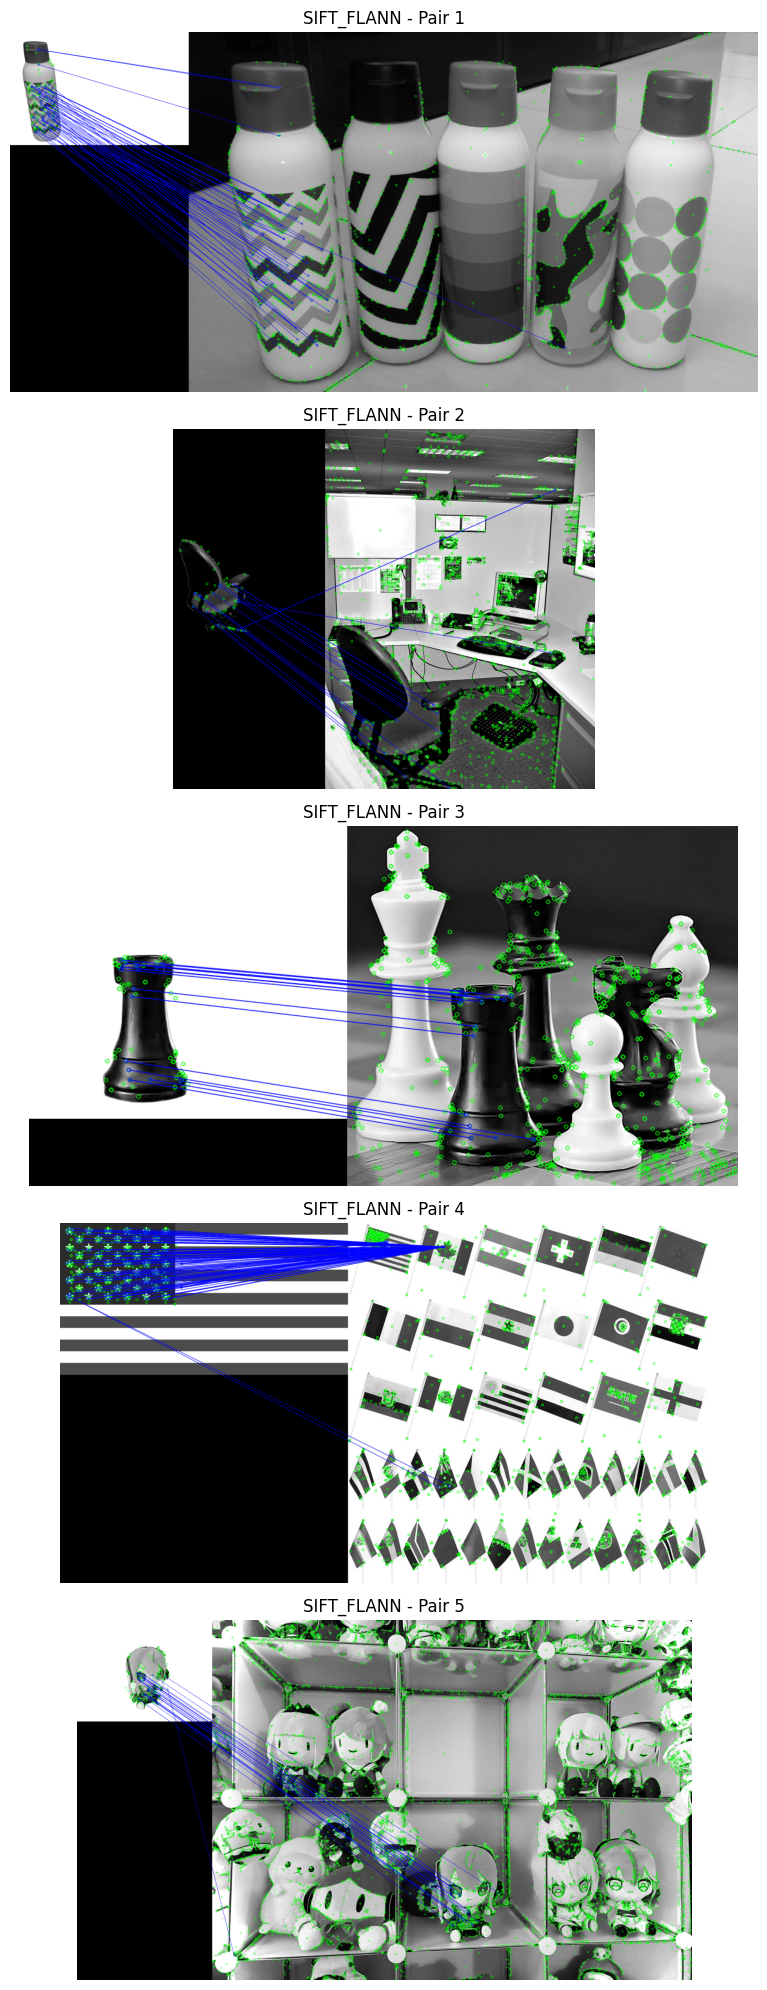

In [15]:
showImage("SIFT_FLANN", RES)